In [58]:
#Librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyodbc

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from scipy.sparse.linalg import svds
 

import warnings
warnings.filterwarnings('ignore')


## 1.Seleccion

In [59]:
# Conexión a base de datos
conn = pyodbc.connect(DRIVER = '{ODBC Driver 17 for SQL Server}',
                      SERVER = 'med000008646',
                      DATABASE = 'BD_BI',
                      UID = 'ussifods',
                      PWD = 'sifods')

In [60]:
#Extraccion del dataset inical 
query1 = """select *  from [dbo].[TMP_ENCUESTAS]"""
df = pd.read_sql_query(query1,conn)
#Cerrar la conexion
conn.close()

In [61]:
df.head()

,CURID,DES_CURSO,NOMBRE_ACTIVIDAD,TIPO_ACTIVIDAD,FEEDBACKID,USUARIO,NOMBRES,APELLIDOS,IDNUMBER,NUM_RESPUESTA,FECHA_REALIZADA,NOMBRE_PREGUNTA,ORDEN_PREGUNTA,TIPO_PREGUNTA,OPCIONES,OPCION_ELEGIDA,RESPUESTA,FECHAREPORTE
0,59,Clase invertida,Encuesta de satisfacción,feedback,131,16701635,MARIA LUCINDA,HIDROGO MEJIA,16701635,2942,2022-07-15 10:35:21,10.\tLa duración del curso para lograr el prop...,29,multichoice,1\n|2\n|3\n|4,3,3\n,2022-10-28 14:29:56
1,59,Clase invertida,Encuesta de satisfacción,feedback,131,16701635,MARIA LUCINDA,HIDROGO MEJIA,16701635,2942,2022-07-15 10:35:21,11.\tLos recursos pedagógicos empleados (video...,30,multichoice,1\n|2\n|3\n|4,3,3\n,2022-10-28 14:29:56
2,59,Clase invertida,Encuesta de satisfacción,feedback,131,16701635,MARIA LUCINDA,HIDROGO MEJIA,16701635,2942,2022-07-15 10:35:21,12.\tLas actividades prácticas y ejemplos pres...,31,multichoice,1\n|2\n|3\n|4,3,3\n,2022-10-28 14:29:56
3,59,Clase invertida,Encuesta de satisfacción,feedback,131,16701635,MARIA LUCINDA,HIDROGO MEJIA,16701635,2942,2022-07-15 10:35:21,13.\tLa evaluación del curso a partir de los c...,32,multichoice,1\n|2\n|3\n|4,3,3\n,2022-10-28 14:29:56
4,59,Clase invertida,Encuesta de satisfacción,feedback,131,16701635,MARIA LUCINDA,HIDROGO MEJIA,16701635,2942,2022-07-15 10:35:21,14.\tLos correos recibidos para culminar el cu...,34,multichoice,1\n|2\n|3\n|4,3,3\n,2022-10-28 14:29:56


# 2.Preprocesamiento

In [62]:
#Numero de docentes unicos y cursos unicos de la data inicial 
docentes_unicos = df.USUARIO.unique()
print(' # Numero de docentes unicos: ' + str(len(docentes_unicos)))
cursos_unicos= df.CURID.unique()
print(' # Numero de cursos unicos: ' + str(len(cursos_unicos)))

 # Numero de docentes unicos: 730
 # Numero de cursos unicos: 16


In [63]:
#Numero de docentes por Cursos 
df1 = df.groupby('DES_CURSO')['IDNUMBER'].nunique()
df1 = pd.DataFrame(df1)
df1.reset_index(inplace=True)
df1.sort_values(by ='IDNUMBER', ascending=False,inplace=True)
df1.head()

,DES_CURSO,IDNUMBER
14,Programa de metodologías STEAM - Secundaria,208
1,Clase invertida,180
0,Alfabetización Digital,125
4,Introducción a la Competencia Digital,114
15,Prácticas saludables para el uso de las tecnol...,109


In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19862 entries, 0 to 19861
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   CURID             19862 non-null  int64         
 1   DES_CURSO         19862 non-null  object        
 2   NOMBRE_ACTIVIDAD  19862 non-null  object        
 3   TIPO_ACTIVIDAD    19862 non-null  object        
 4   FEEDBACKID        19862 non-null  int64         
 5   USUARIO           19862 non-null  object        
 6   NOMBRES           19862 non-null  object        
 7   APELLIDOS         19862 non-null  object        
 8   IDNUMBER          19862 non-null  object        
 9   NUM_RESPUESTA     19862 non-null  int64         
 10  FECHA_REALIZADA   19862 non-null  datetime64[ns]
 11  NOMBRE_PREGUNTA   19862 non-null  object        
 12  ORDEN_PREGUNTA    19862 non-null  int64         
 13  TIPO_PREGUNTA     19862 non-null  object        
 14  OPCIONES          1986

# 3.Transformación

In [65]:
# Comprimir opción elegida
print(df['OPCION_ELEGIDA'].unique())
df.groupby('OPCION_ELEGIDA')['OPCION_ELEGIDA'].count()
## Reemplazamos los valores null por 3
df['OPCION_ELEGIDA']=df['OPCION_ELEGIDA'].fillna(3)
df['OPCION_ELEGIDA']=df['OPCION_ELEGIDA'].astype('int64')

['3' '4' '2' '1' None]


In [66]:
#Curso mejor recomendado
mejor_puntuacion = df.groupby('CURID')['OPCION_ELEGIDA'].mean()
mejor_puntuacion = pd.DataFrame(mejor_puntuacion)
mejor_puntuacion.reset_index(inplace=True)
mejor_puntuacion.sort_values(by= 'OPCION_ELEGIDA', ascending=False, inplace= True)
mejor_puntuacion.head(5)

,CURID,OPCION_ELEGIDA
7,119,3.613636
2,57,3.587719
6,65,3.531692
3,59,3.515556
4,60,3.430037


In [67]:
df0 = df.groupby(['CURID','IDNUMBER'])['OPCION_ELEGIDA'].mean()
df0 = pd.DataFrame(df0)
df0.reset_index(inplace=True)
df0.columns = ['CURID','IDNUMBER','PUNTUACION']
df0['PUNTUACION']= np.round(df0['PUNTUACION'],2)
df0.head(10)

,CURID,IDNUMBER,PUNTUACION
0,55,00513128,3.00
1,55,00818787,3.06
2,55,01112370,3.00
3,55,01158716,4.00
4,55,01335498,3.00
5,55,01683986,3.00
6,55,01888335,2.75
7,55,02296820,2.50
8,55,02744040,3.00
9,55,03661335,4.00


In [69]:
# Pivot de la tabla inicial idnumber, curid y puntuacion
df_pivot = df0.pivot(index='IDNUMBER',columns='CURID',values='PUNTUACION')
df_pivot.head()

CURID,55,56,57,59,60,61,65,119,127,128,579,582,583,584,586,587
IDNUMBER,,,,,,,,,,,,,,,,
00024927,NaN,NaN,NaN,3.93,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00063537,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN
00124735,NaN,NaN,NaN,NaN,NaN,4.0,3.92,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00239334,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN
00240641,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN


# 4.Mineria de datos

In [70]:
# Calculando matrix sparsity 
sparsity_count = df_pivot.isnull().values.sum()
# Contar todas las celdas
full_cont = df_pivot.size
# Numero de escazes del dataset
sparsity = round(sparsity_count / full_cont, 3)
print('El dataset tiene una escasez de : ' + str(sparsity*100)+ '%')

El dataset tiene una escasez de : 89.2%


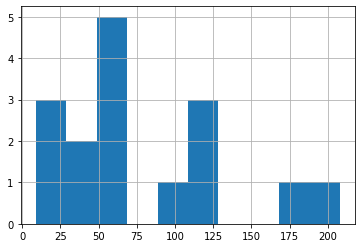

In [71]:
# Contar las celdas ocupadas por columna
count_celdas_ocupadas = df_pivot.notnull().sum()
# Ordenar el resultado de mayot a menor
sorted_count_celdas_ocupadas = count_celdas_ocupadas.sort_values()
# Plot Histograma
sorted_count_celdas_ocupadas.hist()
plt.show()

## Descomposión de valores singulares (SVD)

In [72]:
# Obtener la valoración media de cada usuario
avg_rating = df_pivot.mean(axis=1)
# Centrar las valoraciones de los usuarios entorno a 0
df_pivot_centered = df_pivot.sub(avg_rating, axis=0)
# Rellenar los datos que faltan con 0
df_pivot_centered.fillna(0, inplace=True)
# Comprobar la matriz centrada
print(df_pivot_centered.mean(axis=1))

IDNUMBER
00024927    0.000000e+00
00063537    0.000000e+00
00124735    0.000000e+00
00239334    0.000000e+00
00240641    0.000000e+00
                ...     
80163425    0.000000e+00
80209750    5.551115e-17
80345416    0.000000e+00
80666019    0.000000e+00
99999998   -5.551115e-17
Length: 730, dtype: float64


In [73]:
#Descomponer la Matrix
U, sigma, Vt = svds(df_pivot_centered)
#Converitir el sigma en la diagonal de la matriz
sigma = np.diag(sigma)

In [74]:
#Producto de puntos
U_sigma = np.dot(U,sigma)
#Producto de puntos del resultado
U_sigma_Vt = np.dot(U_sigma, Vt)
#Las medias de las filas contenidas
Calificaciones_descentradas = U_sigma_Vt + avg_rating.values.reshape(-1,1)

calc_pred_df = pd.DataFrame(Calificaciones_descentradas,
                            index=df_pivot.index,
                            columns=df_pivot.columns)

print(calc_pred_df)

CURID          55        56        57        59        60        61   \
IDNUMBER                                                               
00024927  3.930000  3.930000  3.930000  3.930000  3.930000  3.930000   
00063537  3.000000  3.000000  3.000000  3.000000  3.000000  3.000000   
00124735  3.960547  3.959943  3.960352  3.960259  3.959971  3.994049   
00239334  3.000000  3.000000  3.000000  3.000000  3.000000  3.000000   
00240641  2.000000  2.000000  2.000000  2.000000  2.000000  2.000000   
...            ...       ...       ...       ...       ...       ...   
80163425  3.000000  3.000000  3.000000  3.000000  3.000000  3.000000   
80209750  3.009020  3.602633  3.887856  4.003013  3.597290  3.559690   
80345416  3.000000  3.000000  3.000000  3.000000  3.000000  3.000000   
80666019  2.850000  2.850000  2.850000  2.850000  2.850000  2.850000   
99999998  3.387180  3.350352  3.363574  3.391388  3.377562  3.142209   

CURID          65        119       127       128       579     

In [81]:
# Ordenar la valoración del usuario 5 de mayor a menor 
user_100_ratings = calc_pred_df.iloc[0,:].sort_values(ascending=False)
print(user_100_ratings.head(3))

CURID
55    3.93
56    3.93
57    3.93
Name: 00024927, dtype: float64


# 5.Interpretacion Evaluacion

## Validando las predicciones 

In [82]:
# Comparar los metodos de recomendación
# Extraer los valores verdaderos para comparar las predicciones
actual_valor = df_pivot.iloc[:50, :15].values
predict_values = calc_pred_df.iloc[:50,:15].values 
mask = ~np.isnan(actual_valor)
print(mean_squared_error(actual_valor[mask], predict_values[mask],squared=False))

0.012975481662361878


In [83]:
calc_pred_df = pd.DataFrame(calc_pred_df)
calc_pred_df=calc_pred_df.reset_index()
calc_pred_df.head()

CURID,IDNUMBER,55,56,57,59,60,61,65,119,127,128,579,582,583,584,586,587
0,00024927,3.930000,3.930000,3.930000,3.930000,3.930000,3.930000,3.930000,3.930000,3.930000,3.930000,3.930000,3.93,3.930000,3.930000,3.930000,3.930000
1,00063537,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.00,3.000000,3.000000,3.000000,3.000000
2,00124735,3.960547,3.959943,3.960352,3.960259,3.959971,3.994049,3.918122,3.955577,3.961232,3.969977,3.959985,3.96,3.958817,3.961198,3.960007,3.959962
3,00239334,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.00,3.000000,3.000000,3.000000,3.000000
4,00240641,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.00,2.000000,2.000000,2.000000,2.000000


In [85]:
# Obtener dataset de resultados
df_f = calc_pred_df.melt(id_vars='IDNUMBER',var_name='CURID',value_name='PUNTUACION')
df_f['PUNTUACION'] = np.round(df_f['PUNTUACION'],3)
df_f.head()

,IDNUMBER,CURID,PUNTUACION
0,00024927,55,3.930
1,00063537,55,3.000
2,00124735,55,3.961
3,00239334,55,3.000
4,00240641,55,2.000


In [86]:
# Recomendacion de cursos por docente
df_f[df_f['IDNUMBER']== '00124735'].sort_values(by='PUNTUACION', ascending= False).head(3)

,IDNUMBER,CURID,PUNTUACION
3652,00124735,61,3.994
6572,00124735,128,3.970
2,00124735,55,3.961


## Carga de datos

In [26]:
# Credenciales de acceso  a base de datos BI
conn2 =  pyodbc.connect(DRIVER = '{ODBC Driver 17 for SQL Server}',
                      SERVER = 'med000008646',
                      DATABASE = 'BD_BI',
                      UID = 'ussifods',
                      PWD = 'sifods')

cursor = conn2.cursor()

In [27]:
# Borrar los datos de la tabla
cursor.execute("TRUNCATE TABLE [dbo].[TMP_RECOMENDACION]")
conn2.commit()

In [28]:
# Insertar valores 
sql_insert = """ INSERT INTO [dbo].[TMP_RECOMENDACION] VALUES (?,?,?) """
val = df_f[['IDNUMBER','CURID','PUNTUACION']].values.tolist()
cursor.executemany(sql_insert,val)
conn2.commit()
# Cerrar las conexiones
cursor.close()
conn2.close()

In [157]:
#Final
print("Ejecución exitosa : \n" + "se Cargó " + str(df_f.shape[0]) + " registros" )

Ejecución exitosa : 
se Cargó 11680 registros
